In [12]:
# Installation des librairies nécessaires (si pas déjà installées)
# !pip install google-cloud-bigquery pandas matplotlib seaborn

import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

MY_PROJECT_ID = "students-group3" 
# Initialisation du client BigQuery
client = bigquery.Client(project=MY_PROJECT_ID)

print(f"Connecté au projet : {MY_PROJECT_ID}")


Connecté au projet : students-group3


In [13]:
# 1. Chargement des Films (Movies)
# On récupère l'ID, le titre et les genres.
query_movies = """
    SELECT 
        movieId,
        title,
        genres
    FROM 
        `master-ai-cloud.MoviePlatform.movies`
"""
df_movies = client.query(query_movies).to_dataframe()

# 2. Chargement des Notes (Ratings)
# On limite pour l'instant pour tester, mais pour le modèle final on prendra tout.
# Le document conseille d'utiliser LIMIT pour l'exploration[cite: 34].
# Ici, je mets une limite pour l'EDA rapide, on l'enlèvera pour l'entraînement.
query_ratings = """
    SELECT 
        userId,
        movieId,
        rating,
        timestamp
    FROM 
        `master-ai-cloud.MoviePlatform.ratings`
    LIMIT 100000 
"""
# Note: J'ai mis 100k lignes pour avoir assez de stats sans tout charger si la table est géante.
df_ratings = client.query(query_ratings).to_dataframe()

print(f"Films chargés : {df_movies.shape}")
print(f"Notes chargées : {df_ratings.shape}")

Films chargés : (10329, 3)
Notes chargées : (100000, 4)


In [14]:
# A. Aperçu des données
display(df_movies.head())
display(df_ratings.head())

# B. Vérification des valeurs manquantes
print("\nValeurs manquantes Films :")
print(df_movies.isnull().sum())
print("\nValeurs manquantes Ratings :")
print(df_ratings.isnull().sum())


,movieId,title,genres
0,126929,Li'l Quinquin ( ),(no genres listed)
1,135460,Pablo (2012),(no genres listed)
2,138863,The Big Broadcast of 1936 (1935),(no genres listed)
3,141305,Round Trip to Heaven (1992),(no genres listed)
4,141472,The 50 Year Argument (2014),(no genres listed)


,userId,movieId,rating,timestamp
0,1,204,0.5,1217895786
1,1,256,0.5,1217895764
2,1,277,0.5,1217895772
3,1,719,0.5,1217895799
4,1,45950,0.5,1217897813



Valeurs manquantes Films :
movieId    0
title      0
genres     0
dtype: int64

Valeurs manquantes Ratings :
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


/var/tmp/ipykernel_6141/1871347876.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_ratings, palette='viridis')


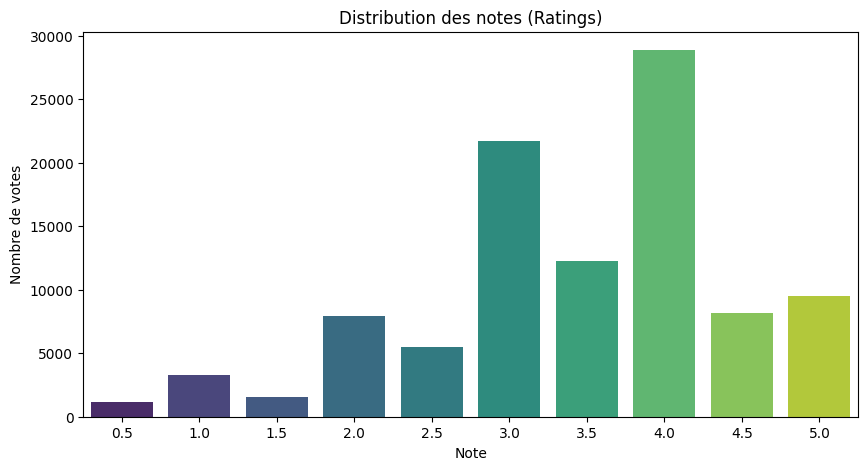

In [15]:

# C. Analyse de la distribution des notes (Très important pour comprendre le biais utilisateur)
plt.figure(figsize=(10,5))
sns.countplot(x='rating', data=df_ratings, palette='viridis')
plt.title("Distribution des notes (Ratings)")
plt.xlabel("Note")
plt.ylabel("Nombre de votes")
plt.show()


In [16]:

# D. Quels sont les films les plus notés ? (Popularité)
# On joint les tables pour avoir le titre
top_movies = df_ratings.groupby('movieId').count()['rating'].sort_values(ascending=False).head(10)
top_movies_titles = df_movies[df_movies['movieId'].isin(top_movies.index)]
print("\nTop 10 des films les plus notés :")
display(top_movies_titles)

# E. Analyse des utilisateurs : Combien de notes donne un utilisateur moyen ?
user_counts = df_ratings.groupby('userId').count()['rating']
print(f"\nNombre moyen de notes par utilisateur : {user_counts.mean():.2f}")
print(f"Nombre médian de notes par utilisateur : {user_counts.median():.2f}")


Top 10 des films les plus notés :


,movieId,title,genres
447,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
516,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
1386,110,Braveheart (1995),Action|Drama|War
1557,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
1604,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
3695,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
4629,356,Forrest Gump (1994),Comedy|Drama|Romance|War
5459,318,"Shawshank Redemption, The (1994)",Crime|Drama
6067,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
10147,457,"Fugitive, The (1993)",Thriller



Nombre moyen de notes par utilisateur : 149.70
Nombre médian de notes par utilisateur : 66.00


In [33]:
from recommender import MovieRecommender
import pandas as pd



# Test du moteur
rec = MovieRecommender()
rec.load_data(df_ratings, df_movies)
rec.train()
print("Modèle entraîné avec succès !")

# Test recommandation pour utilisateur 1
res = rec.get_recommendations_for_user(1, top_n=2)
print("Recommandations pour l'utilisateur 1 :")
print(res)

Données chargées avec succès.
Début de l'entraînement du modèle SVD...
RMSE: 0.8512
Modèle entraîné. RMSE (Erreur moyenne) : 0.8512
Modèle entraîné avec succès !
Recommandations pour l'utilisateur 1 :
   movieId                                           title       genres  \
0     1172  Cinema Paradiso (Nuovo cinema Paradiso) (1989)        Drama   
1      318                Shawshank Redemption, The (1994)  Crime|Drama   

   predicted_score  
0             4.31  
1             4.22  


In [37]:
# 1. On définit un nouvel utilisateur (ID 999)
new_user_id = 9999

# 2. On regarde ses recommandations AVANT d'ajouter des notes
print("--- AVANT l'ajout de notes ---")
recs_before = rec.get_recommendations_for_user(new_user_id, top_n=3)
print(recs_before)

# 3. On crée de nouvelles notes pour cet utilisateur
# Supposons qu'il adore les films d'Action (ID 3 dans notre petit df_movies précédent)
new_ratings = pd.DataFrame({
    'userId': [new_user_id],
    'movieId': [3],  # Heat (Action)
    'rating': [5.0]
})

print("\n--- Ajout d'une note de 5/5 pour le film ID 3 (Action) ---")
# On utilise la fonction add_new_user_ratings
df_ratings = rec.add_new_user_ratings(new_ratings, df_ratings)

# 4. On regarde ses recommandations APRÈS l'ajout
print("\n--- APRÈS l'ajout de notes ---")
recs_after = rec.get_recommendations_for_user(new_user_id, top_n=3)
print(recs_after)

--- AVANT l'ajout de notes ---
   movieId                  title                      genres  predicted_score
0      858  Godfather, The (1972)                 Crime|Drama                5
1      923    Citizen Kane (1941)               Drama|Mystery                5
2     1212  Third Man, The (1949)  Film-Noir|Mystery|Thriller                5

--- Ajout d'une note de 5/5 pour le film ID 3 (Action) ---
Données chargées avec succès.
Modèle mis à jour avec les nouvelles notes.

--- APRÈS l'ajout de notes ---
   movieId                                       title  \
0     3000    Princess Mononoke (Mononoke-hime) (1997)   
1     1136      Monty Python and the Holy Grail (1975)   
2     2324  Life Is Beautiful (La Vita è bella) (1997)   

                                     genres  predicted_score  
0  Action|Adventure|Animation|Drama|Fantasy                5  
1                  Adventure|Comedy|Fantasy                5  
2                  Comedy|Drama|Romance|War                5  


In [36]:
# Extraction du film avec movieId == 3
film_info = df_movies.loc[df_movies['movieId'] ==3]

if not film_info.empty:
    print("Film trouvé :")
    print(film_info)
    
    # Pour récupérer juste le titre ou le genre :
    titre = film_info['title'].values[0]
    genres = film_info['genres'].values[0]
    print(f"\nLe film ID 3 est '{titre}' et ses genres sont : {genres}")
else:
    print("Le film avec l'ID 3 n'existe pas dans le DataFrame actuel.")

Film trouvé :
      movieId                    title          genres
4964        3  Grumpier Old Men (1995)  Comedy|Romance

Le film ID 3 est 'Grumpier Old Men (1995)' et ses genres sont : Comedy|Romance


In [34]:
# 1. Extraire toutes les notes de l'utilisateur 1
user_1_ratings = df_ratings[df_ratings['userId'] == 1]

# 2. Joindre avec df_movies pour voir les titres et les genres (plus lisible que juste les IDs)
user_1_history = pd.merge(user_1_ratings, df_movies, on='movieId')

# 3. Afficher le résultat trié par note (les films qu'il a préférés en haut)
print("Historique des notes de l'utilisateur 1 :")
print(user_1_history.sort_values(by='rating', ascending=False))

Historique des notes de l'utilisateur 1 :
     userId  movieId  rating   timestamp  \
112       1    48516     5.0  1217896206   
106       1     1221     5.0  1217897613   
102       1      858     5.0  1217896428   
103       1      912     5.0  1217897623   
104       1     1136     5.0  1217897630   
..      ...      ...     ...         ...   
2         1      277     0.5  1217895772   
1         1      256     0.5  1217895764   
4         1    45950     0.5  1217897813   
5         1    57949     0.5  1217896004   
0         1      204     0.5  1217895786   

                                      title                    genres  
112                    Departed, The (2006)      Crime|Drama|Thriller  
106          Godfather: Part II, The (1974)               Crime|Drama  
102                   Godfather, The (1972)               Crime|Drama  
103                       Casablanca (1942)             Drama|Romance  
104  Monty Python and the Holy Grail (1975)  Adventure|Comedy|Fantasy